In [2]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *

In [3]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator(sigma=[0.001, 0.003, 0.01, 0.03],
                                 p=[0.01, 0.05, 0.1, 0.2])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [4]:
#task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
#task = Add_Task(3, 5, deterministic=True, tau_task=1)
#task = Sine_Wave(0.05, )
task = Delay_Nonmatch_Task(stim_duration=3,
                           report_duration=3,
                           delay_duration=5)
N_train = 500000
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 64

n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

#learn_alg = REINFORCE(rnn, sigma=params['sigma'], decay=params['decay'], loss_decay=params['loss_decay'])
#learn_alg = REINFORCE(rnn, sigma=params['sigma'], decay=1, loss_decay=0.01)
#if params['learn_alg'] == 'RFLO':
#    learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
#if params['learn_alg'] == 'REIN':
learn_alg = Miconi_REINFORCE(rnn, sigma=params['sigma'], p=params['p'], tau_e_trace=0.05)
#if params['learn_alg'] == 'RTRL':
#    learn_alg = RTRL(rnn, L2_reg=0.0001, L1_reg=0.0001)
#if params['learn_alg'] == 'BPTT':
#    learn_alg = Efficient_BPTT(rnn, T_truncation=task.time_steps_per_trial, L2_reg=0.0001, L1_reg=0.0001)
#learn_alg = Only_Output_Weights(rnn)
#optimizer = SGD_Momentum(lr=0.001, mu=0.6)
optimizer = Stochastic_Gradient_Descent(lr=0.001)

#monitors = ['learn_alg.h_avg', 'rnn.h', 'learn_alg.e_trace-norm', 'learn_alg.e_immediate-norm']
monitors = []

sim = Simulation(rnn,
                 time_steps_per_trial=task.time_steps_per_trial,
                 reset_sigma=0.001,
                 trial_mask=task.trial_mask)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

Progress: 10.0% complete 
Time Elapsed: 37.1s 
Test loss: 0.03804486133272219 

Progress: 20.0% complete 
Time Elapsed: 74.4s 
Test loss: 0.036215930218991776 

Progress: 30.0% complete 
Time Elapsed: 111.8s 
Test loss: 0.03544146655988363 

Progress: 40.0% complete 
Time Elapsed: 149.3s 
Test loss: 0.034722621471068214 

Progress: 50.0% complete 
Time Elapsed: 186.7s 
Test loss: 0.03417380665593074 

Progress: 60.0% complete 
Time Elapsed: 224.1s 
Test loss: 0.03381711190066682 

Progress: 70.0% complete 
Time Elapsed: 261.5s 
Test loss: 0.03410713084289477 

Progress: 80.0% complete 
Time Elapsed: 298.9s 
Test loss: 0.034592016170401314 

Progress: 90.0% complete 
Time Elapsed: 336.3s 
Test loss: 0.034349753262139286 



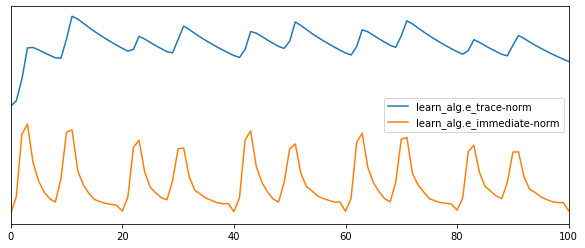

In [4]:
#fig = plot_signals({k:np.nan_to_num(sim.mons[k]) for k in sim.mons.keys() if 'norm' in k},
#                   signal_clips={k:500 for k in sim.mons.keys() if 'norm' in k})
#plt.xlim([0, 100])
#figs_path = 'figs/miconi_task/'
#fig.savefig(os.path.join(figs_path, 'e-norms_filter.pdf'), format='pdf')

In [ ]:
#sim.mons['learn_alg.e_immediate-norm']

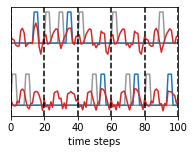

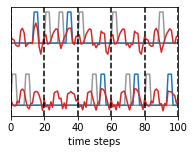

In [7]:
#plot_output_from_checkpoint(sim.checkpoints[max(sim.checkpoints.keys())], data, xlim=100,
#                            time_steps_per_trial=task.time_steps_per_trial,
#                            trial_mask=task.trial_mask,
#                            reset_sigma=0.003)
#plot_output_from_checkpoint(sim.checkpoints[max(sim.checkpoints.keys())], data, xlim=100)

In [ ]:
test_sim = Simulation(rnn)
test_sim.run(data, mode='test', monitors=['rnn.loss_'], verbose=False)
processed_data = np.mean(test_sim.mons['rnn.loss_'])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'task': task,
          'config': params, 'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [10]:
###Truncate file above
file_name = 'low_alpha'
job_name = 'miconi_rein_grid6'
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py ../cluster_main_scripts/{}.py'.format(file_name, job_name))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook low_alpha.ipynb to script
[NbConvertApp] Writing 6873 bytes to low_alpha.py
awk: 1: unexpected character '.'


In [11]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name))
job_id_1 = submit_job('../job_scripts/{}.s'.format(job_name), n_jobs)

rm: cannot remove '/scratch/oem214/learning-dynamics/results/miconi_rein_grid6/result_*': No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/test.py
vanilla-rtrl/test_2.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/.ipynb_checkpoints/test_interface-checkpoint.ipynb
vanilla-rtrl/__pycache__/
vanilla-rtrl/__pycache__/analysis.cpython-36.pyc
vanilla-rtrl/__pycache__/analysis_funcs.cpython-36.pyc
vanilla-rtrl/__pycache__/analysis_func

vanilla-rtrl/optimizers/SGD_Momentum.py
vanilla-rtrl/optimizers/Stochastic_Gradient_Descent.py
vanilla-rtrl/optimizers/__init__.py
vanilla-rtrl/optimizers/__pycache__/
vanilla-rtrl/optimizers/__pycache__/Adam.cpython-37.pyc
vanilla-rtrl/optimizers/__pycache__/Adam.cpython-38.pyc
vanilla-rtrl/optimizers/__pycache__/Optimizer.cpython-37.pyc
vanilla-rtrl/optimizers/__pycache__/Optimizer.cpython-38.pyc
vanilla-rtrl/optimizers/__pycache__/SGD_Momentum.cpython-37.pyc
vanilla-rtrl/optimizers/__pycache__/SGD_Momentum.cpython-38.pyc
vanilla-rtrl/optimizers/__pycache__/Stochastic_Gradient_Descent.cpython-37.pyc
vanilla-rtrl/optimizers/__pycache__/Stochastic_Gradient_Descent.cpython-38.pyc
vanilla-rtrl/optimizers/__pycache__/__init__.cpython-37.pyc
vanilla-rtrl/optimizers/__pycache__/__init__.cpython-38.pyc
vanilla-rtrl/plotting/
vanilla-rtrl/plotting/State_Space_Analysis.py
vanilla-rtrl/plotting/__init__.py
vanilla-rtrl/plotting/checkpoint_plots.py
vanilla-rtrl/plotting/misc.py
vanilla-rtrl/plot

In [12]:
job_name = 'miconi_rein_grid6'

In [14]:
###Get job status
get_ipython().system('squeue -u oem214')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          10010526        cm  jupyter   oem214  R   21:49:48      1 cm07
          10034308        cm  jupyter   oem214  R    3:24:37      1 cm02


In [15]:
configs_array, results_array, key_order, sim_dict = unpack_processed_data('../job_scripts/{}.s'.format(job_name))

In [ ]:
configs_array['learn_alg'] = [0, 1, 2]
fig = plot_2d_array_of_config_results(configs_array, results_array, key_order,
                                      log_scale=False, tick_rounding=5, vmin=0, vmax=0.5)

In [16]:
task_dict = {k: Delay_Nonmatch_Task(delay_duration=int(k.split('_')[0])) for k in sim_dict.keys()}
fig = plot_1d_or_2d_array_of_config_examples(configs_array, results_array, key_order, sim_dict, data=None,
                                             task_dict=task_dict, N_task_data=200, xlim=200)

ValueError: invalid literal for int() with base 10: '0.001'

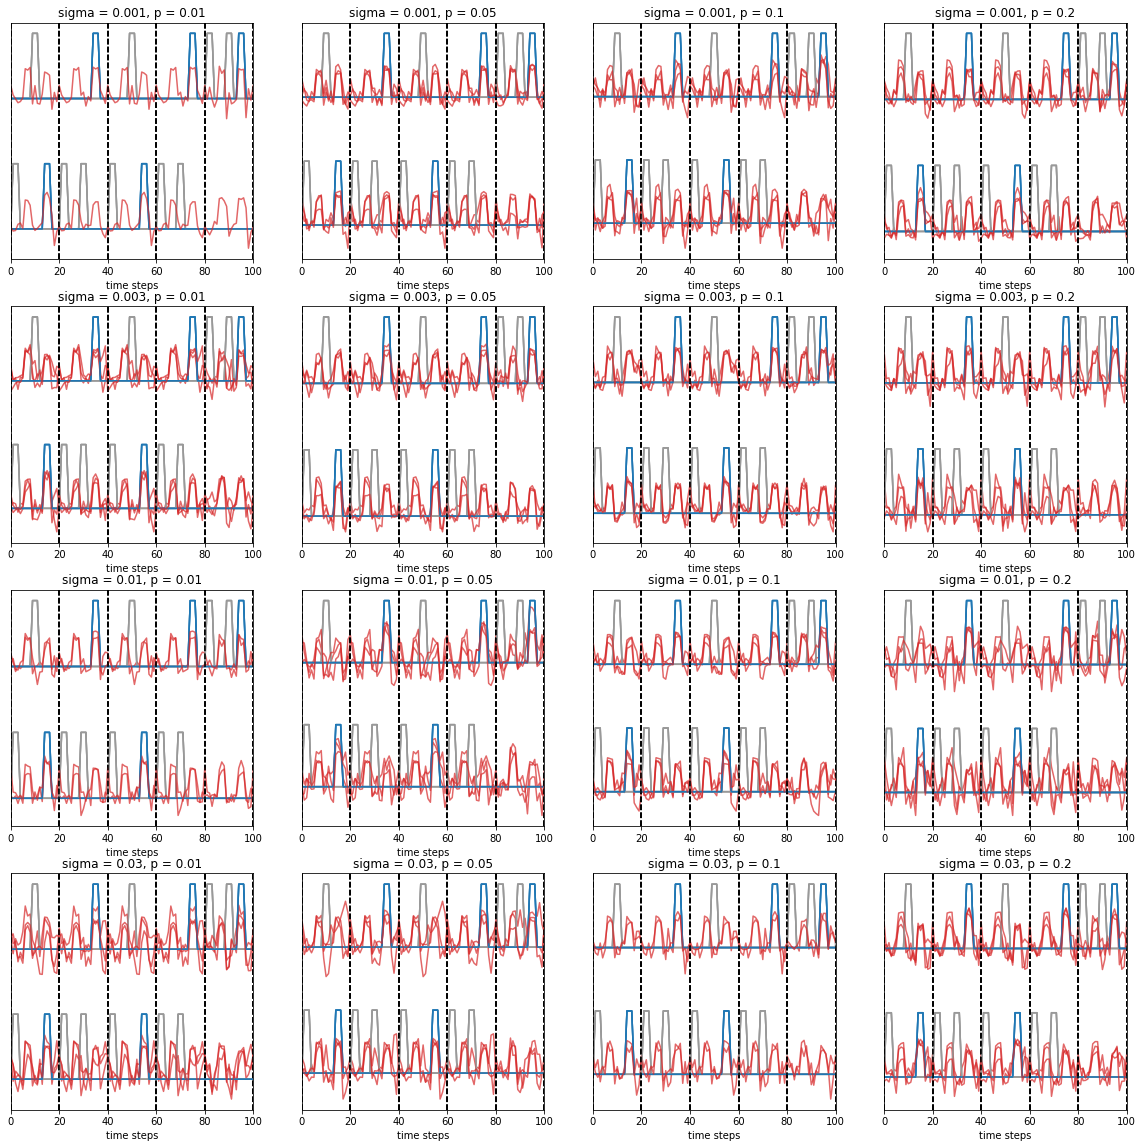

In [18]:
task = Delay_Nonmatch_Task(stim_duration=3, report_duration=3, delay_duration=5)
data = task.gen_data(0, 200)
fig = plot_1d_or_2d_array_of_config_examples(configs_array, results_array, key_order, sim_dict, data=data,
                                             xlim=100)

In [ ]:
task-

In [ ]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order, tick_rounding=5,
                                            vmin=0, vmax=0.2)

In [19]:
figs_path = 'figs/miconi_task/'
fig.savefig(os.path.join(figs_path, '{}.pdf'.format(job_name)), format='pdf')

In [ ]:
np.where(results_array.mean(-1) < 0.45)

In [ ]:
key_order

In [ ]:
sim_dict.keys()

In [ ]:
for i_alpha, alpha in enumerate([0.01, 0.05, 0.1, 0.2, 0.5, 0.8]):
    sim = sim_dict['{}_0'.format(alpha)]
    fig = plot_output_from_checkpoint(sim.checkpoints[max(sim.checkpoints.keys())], data)
    plt.title('alpha = {}'.format(alpha))
    fig.savefig(os.path.join(figs_path, 'best_config_alpha={}.pdf'.format(i_alpha)), format='pdf')

In [ ]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 200000
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

In [ ]:
from scipy.spatial import distance

In [ ]:
import numpy as np
help(np.vstack)